In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", 200)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
#from sklearn.feature_selection import SequentialFeatureSelector

In [2]:
df = pd.read_csv('housing_clean.csv', index_col=0)
df.shape

(2374, 98)

### Dummify Nominal Features

In [3]:
categ_nom = ['MSSubClass','BldgType','HouseStyle','SaleType','SaleCondition','MiscFeature',
             'Fence','GarageType','RoofStyle','RoofMatl','exterior_covering','MasVnrType',
             'MSZoning','Street','LotShape','LandContour','LotConfig','LandSlope','Neighborhood',
             'Alley','condition','Foundation','Utilities','Heating','CentralAir','MoSold','Electrical','QrtSold']

In [4]:
df = pd.get_dummies(df, columns=categ_nom, drop_first=True)

### Remove original columns that have been ordinalized

In [5]:
df = df.drop(columns=[col for col in df.columns if col.endswith('_todrop')])

### Build base model

In [6]:
y = df['SalePrice'];
x = df.drop(['SalePrice', 'PID'], axis = 1)

In [19]:
gbr = GradientBoostingRegressor();
gbr.set_params(random_state=0);

gbr.fit(x, y)

GradientBoostingRegressor(random_state=0)

In [20]:
gbr.score(x, y)

0.968427132581351

In [21]:
feature_importance = pd.DataFrame({"Features": x.columns, "Importance":gbr.feature_importances_})

In [22]:
feature_importance.sort_values("Importance", ascending = False, inplace=True);
feature_importance.head(10)

,Features,Importance
3,OverallQual,0.476909
0,GrLivArea,0.144497
11,TotalBsmtSF,0.051612
12,1stFlrSF,0.045237
24,GarageCars,0.032281
8,BsmtFinSF1,0.028919
25,GarageArea,0.027265
47,ExterQual_ordinal,0.019344
2,LotArea,0.018157
5,YearBuilt,0.017391


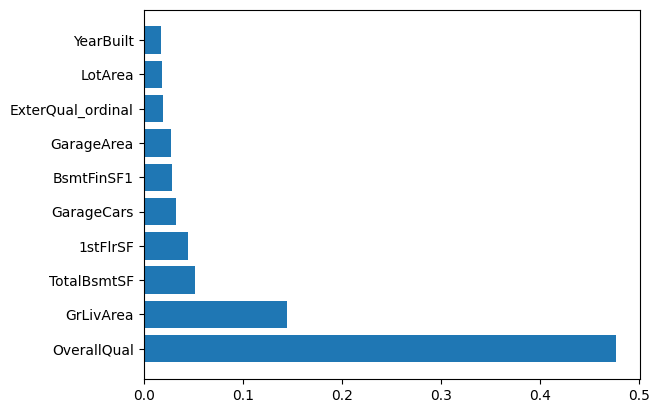

In [23]:
temp = feature_importance.iloc[:10,]
plt.barh(temp["Features"], temp["Importance"]);

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0);


gbr.fit(x_train, y_train)

GradientBoostingRegressor(random_state=0)

In [25]:
# overfitting issue 
print("The train score: %.4f" %gbr.score(x_train, y_train));
print("The test score: %.4f" %gbr.score(x_test, y_test));

The train score: 0.9731
The test score: 0.9311


In [26]:
feature_importance = pd.DataFrame({"Features": x.columns, "Importance":gbr.feature_importances_})

In [27]:
feature_importance.sort_values("Importance", ascending = False, inplace=True);
feature_importance.head(10)

,Features,Importance
3,OverallQual,0.482122
0,GrLivArea,0.163386
8,BsmtFinSF1,0.042456
12,1stFlrSF,0.033207
11,TotalBsmtSF,0.030686
47,ExterQual_ordinal,0.029205
24,GarageCars,0.021432
25,GarageArea,0.017559
2,LotArea,0.016318
7,MasVnrArea,0.014948


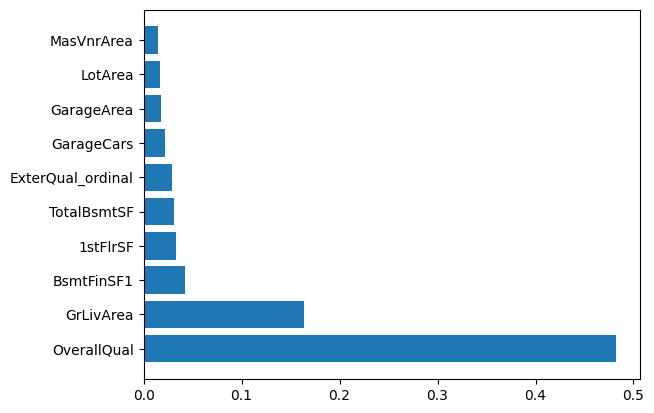

In [28]:
temp = feature_importance.iloc[:10,]
plt.barh(temp["Features"], temp["Importance"]);

### Setting parameter grid

In [35]:
param_grid = {
    'n_estimators': range(50, 200, 50),
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
#     'max_features': range(20, 100, 20)
}

### Initialize Model and Grid Search

In [36]:
gbr = GradientBoostingRegressor(random_state=20)

grid_search_gbr = GridSearchCV(estimator=gbr,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=0,
                           scoring='r2')

grid_search_gbr.fit(x_train, y_train)
%time grid_search_gbr.fit(x_train, y_train)

CPU times: user 3.49 s, sys: 1.53 s, total: 5.01 s
Wall time: 2min 39s


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=20),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5], 'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': range(50, 200, 50)},
             scoring='r2')

### View the best parameters and score

In [37]:
print("Best Parameters:", grid_search_gbr.best_params_)
print("Best Score R square:", grid_search_gbr.best_score_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best Score R square: 0.9018550740572027


In [38]:
best_gbr = grid_search_gbr.best_estimator_

In [39]:
best_gbr.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_iter_no_change': None,
 'random_state': 20,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [40]:
best_gbr

GradientBoostingRegressor(max_depth=4, n_estimators=150, random_state=20)

### Evaluate on Test Set

In [41]:
final_gbr = best_gbr.fit(x_train, y_train)

In [42]:
y_train_pred = final_gbr.predict(x_train)
y_test_pred = final_gbr.predict(x_test)

In [43]:
# R2
r2_5kf_train = final_gbr.score(x_train, y_train)
r2_5kf_test = final_gbr.score(x_test, y_test)

In [44]:
print(f"Train R square: {r2_5kf_train:.4f}")
print(f"Test R square: {r2_5kf_test:.4f}") 

Train R square: 0.9884
Test R square: 0.9353


In [45]:
# root mean squared error, lower is better
# sensitive to outliers
# tells you the average size of the error in prediction — in dollar terms
rmse_5kf_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_5kf_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

In [46]:
print(f"Train Root Mean Squared Error: {rmse_5kf_train:.2f}")
print(f"Test Root Mean Squared Error: {rmse_5kf_test:.2f}")

Train Root Mean Squared Error: 8226.42
Test Root Mean Squared Error: 18504.97


In [51]:
gbr_feature_importance_final = pd.DataFrame({"model": "gradient_boosting_5fk",
                                            "features": x.columns, 
                                            "importance":final_gbr.feature_importances_})

In [52]:
gbr_feature_importance_final

,model,features,importance
0,gradient_boosting_5fk,GrLivArea,0.147509
1,gradient_boosting_5fk,LotFrontage,0.005107
2,gradient_boosting_5fk,LotArea,0.016419
3,gradient_boosting_5fk,OverallQual,0.526306
4,gradient_boosting_5fk,OverallCond,0.004481
...,...,...,...
276,gradient_boosting_5fk,Electrical_FuseP,0.000000
277,gradient_boosting_5fk,Electrical_SBrkr,0.000000
278,gradient_boosting_5fk,QrtSold_Q2,0.000012
279,gradient_boosting_5fk,QrtSold_Q3,0.000084


In [53]:
gbr_feature_importance_final.sort_values("importance", ascending = False, inplace=True);
gbr_feature_importance_final.head(10)

,model,features,importance
3,gradient_boosting_5fk,OverallQual,0.526306
0,gradient_boosting_5fk,GrLivArea,0.147509
11,gradient_boosting_5fk,TotalBsmtSF,0.030675
12,gradient_boosting_5fk,1stFlrSF,0.029313
47,gradient_boosting_5fk,ExterQual_ordinal,0.028630
8,gradient_boosting_5fk,BsmtFinSF1,0.027266
25,gradient_boosting_5fk,GarageArea,0.017839
2,gradient_boosting_5fk,LotArea,0.016419
7,gradient_boosting_5fk,MasVnrArea,0.016156
41,gradient_boosting_5fk,KitchenQual_ordinal,0.015293


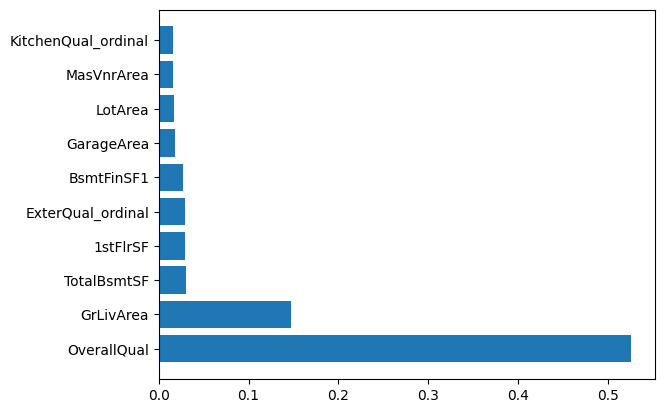

In [54]:
temp = gbr_feature_importance_final.iloc[:10,]
plt.barh(temp["features"], temp["importance"]);

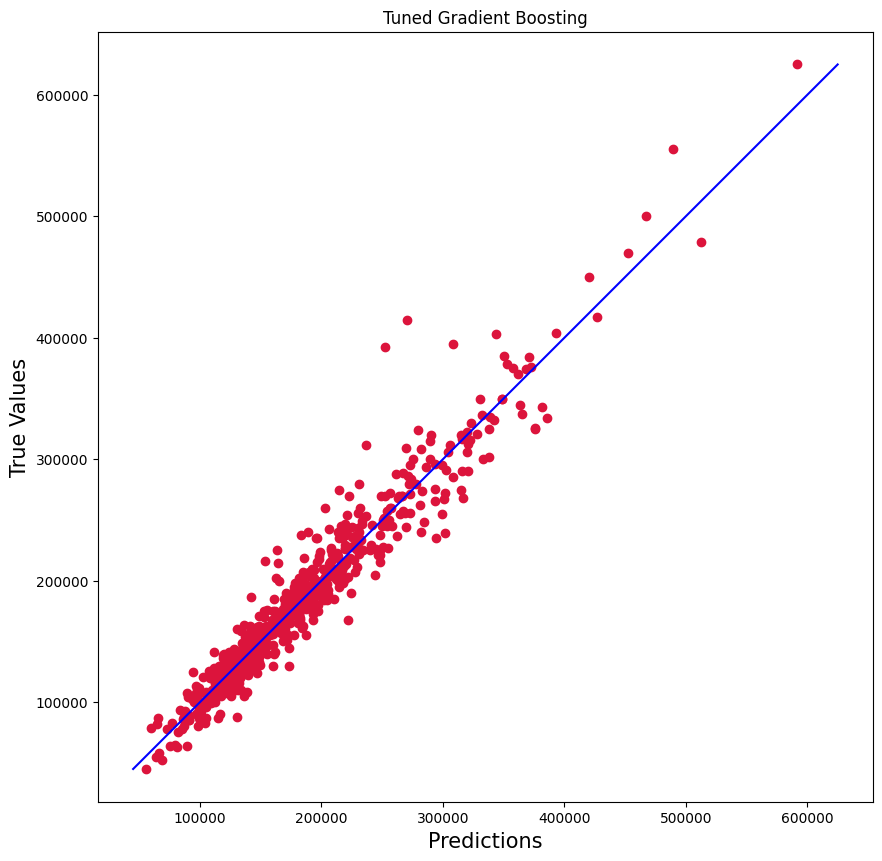

In [55]:
plt.figure(figsize=(10,10))
plt.scatter(y_test_pred, y_test, c='crimson')

plt.title('Tuned Gradient Boosting')
p1 = max(max(y_test_pred), max(y_test))
p2 = min(min(y_test_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Predictions', fontsize=15)
plt.ylabel('True Values', fontsize=15)
plt.axis('equal')
plt.show()

### SHAP
- A SHAP value tells you how much a particular feature pushes the model’s predicted house price up or down, compared to the average prediction across the dataset.

In [ ]:
# Say the average predicted price is $200,000
# If for House A, the SHAP value for GrLivArea is +15,000, 
# that means the model believes the GrLivArea of House A contributes +$15,000 to the price, 
# compared to the average. If for House B, the SHAP value is -5,000, 
# that means the GrLivArea of House B is lowering the prediction by $5,000 from the average.

In [56]:
import shap

# Fit explainer on train data
explainer = shap.Explainer(final_gbr)

# Evaluate SHAP values on test set
shap_values = explainer.shap_values(x_test)

#This balances accurate attribution with realistic performance evaluation.

In [58]:
# SHAP feature importance
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Create a DataFrame for easier viewing and sorting
shap_importance = pd.DataFrame({
    'feature': x.columns,
    'mean_abs_shap': mean_abs_shap_values
})

# Sort in descending order
shap_importance_sorted = shap_importance.sort_values(by='mean_abs_shap', ascending=False)

# Display
print(shap_importance_sorted.head(30))

# how to interpret:
# # On average, the feature OverallQual changes the model’s prediction by 14,566 units of currency (likely dollars), 
# either increasing or decreasing the predicted house price.

                  feature  mean_abs_shap
3             OverallQual   21187.730596
0               GrLivArea   14832.328991
11            TotalBsmtSF    4883.741315
8              BsmtFinSF1    4095.194028
47      ExterQual_ordinal    3863.436272
2                 LotArea    3265.264252
41    KitchenQual_ordinal    3251.608408
5               YearBuilt    3124.488536
24             GarageCars    2595.719409
12               1stFlrSF    2593.017263
25             GarageArea    2153.942089
4             OverallCond    2048.737041
45   BsmtFinType1_ordinal    2038.626136
38    FireplaceQu_ordinal    1801.128327
6            YearRemodAdd    1799.559815
34   GarageFinish_ordinal    1689.081278
7              MasVnrArea    1324.301557
22             Fireplaces    1246.401760
42       BsmtQual_ordinal    1148.619523
17               FullBath     957.785892
44   BsmtExposure_ordinal     950.316689
50      house_age_derived     828.113529
26             WoodDeckSF     791.916777
210  Neighborhoo

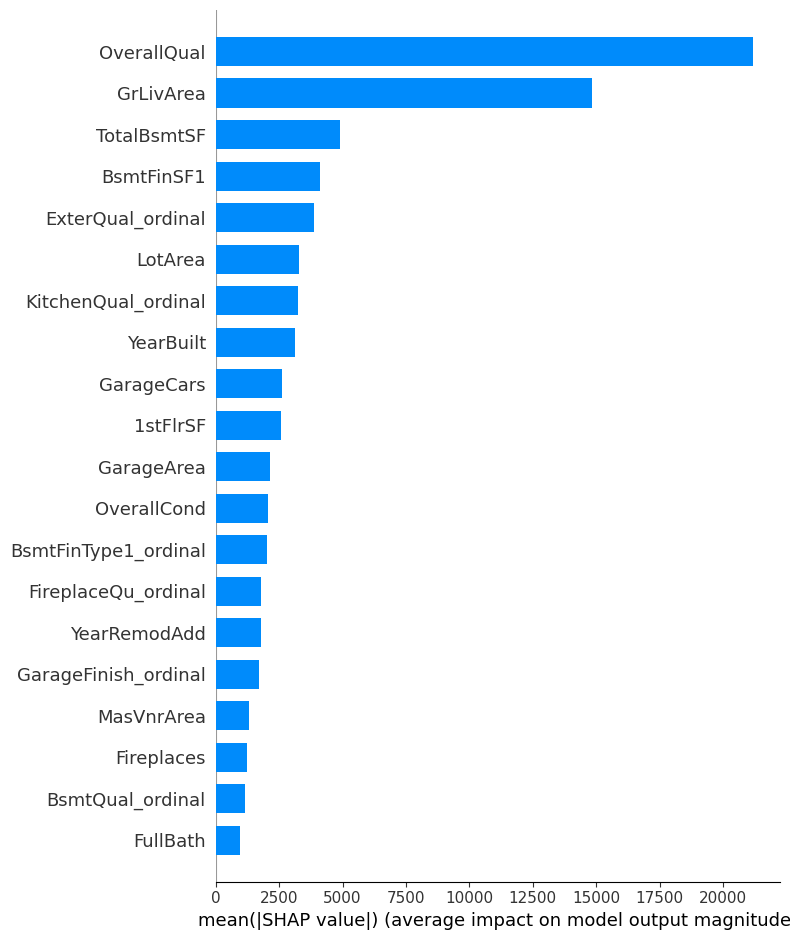

In [59]:
# to visualize the mean abs of SHAP value using summary bar plot
shap.summary_plot(shap_values, x_test, plot_type='bar')

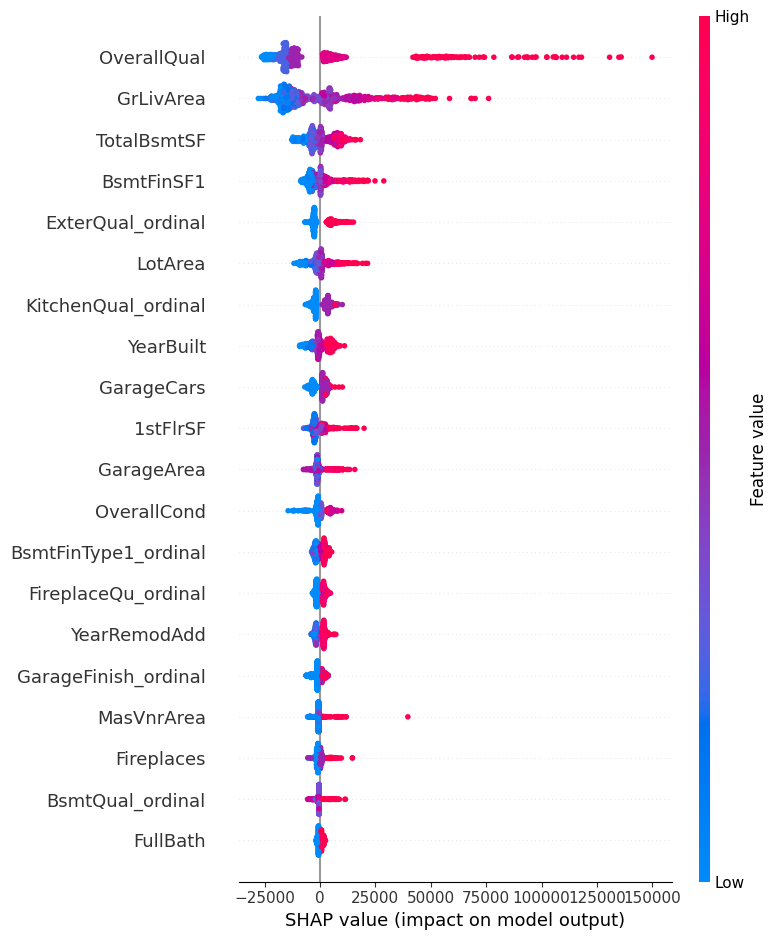

In [60]:
# summary violin plot
shap.summary_plot(shap_values, x_test)

In [ ]:
# How to Read the Violin Plot
# ✅ 1. Width of the Violin (Horizontal Spread)

# Wider areas indicate more data points with similar SHAP values.

# This shows the distribution of how much that feature affects predictions across your dataset.

# ✅ 2. Color Gradient (Red → Blue)

# Each dot is colored by the actual value of the feature:

# Red = High feature value

# Blue = Low feature value

# This helps you understand the direction of the effect.

# For example, if red dots are mostly on the right (positive SHAP values), high values of that feature increase the prediction (e.g., higher price).

# If blue dots are on the left (negative SHAP values), low values decrease the prediction.

# ✅ 3. X-Axis (SHAP Value)

# Represents the magnitude and direction of impact on the model’s prediction.

# A value of +5000 means the feature adds $5,000 (for a house price model).

# A value of -3000 means it subtracts $3,000 from the prediction.

### SHAP Dependence Plot
- In a SHAP dependence plot, the x-axis shows the value of the feature you specified, and the y-axis shows the SHAP value (i.e., the feature’s contribution to the model output). But if you’re seeing a second feature encoded on the plot, that’s expected and by design. The second feature (by color) is there to show interactions. The SHAP dependence plot automatically colors the points by the most correlated feature with the one on the x-axis. This helps uncover interactions between features.

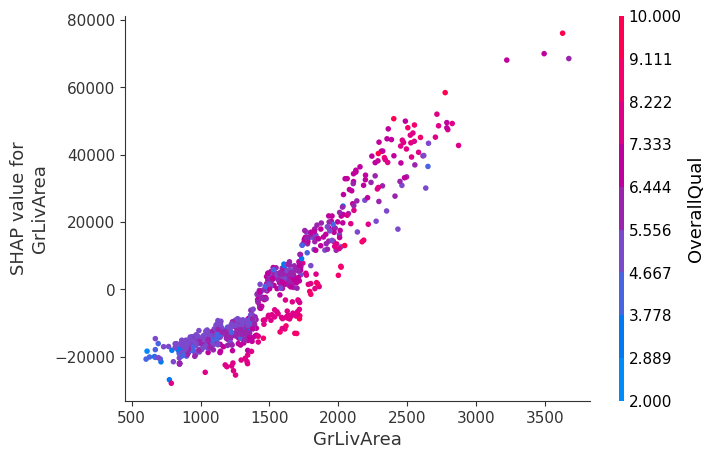

In [61]:
shap.dependence_plot('GrLivArea', shap_values, x_test)

# if don't want to show the second y-axis
#shap.dependence_plot('GrLivArea', shap_values, x_test, interaction_index=None)

<Figure size 600x400 with 0 Axes>

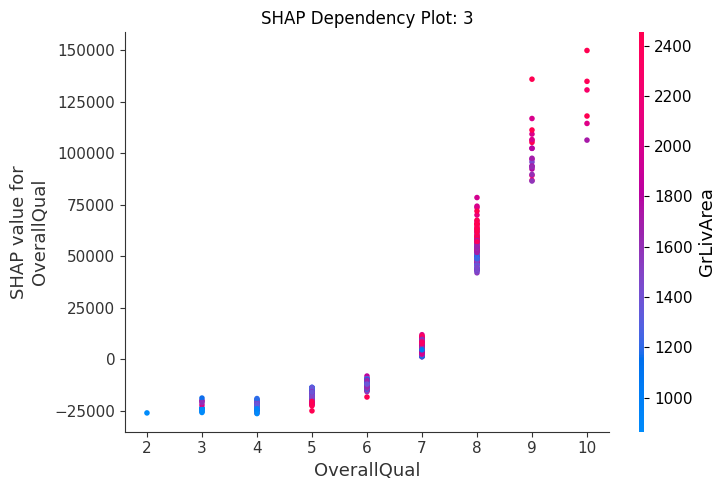

<Figure size 600x400 with 0 Axes>

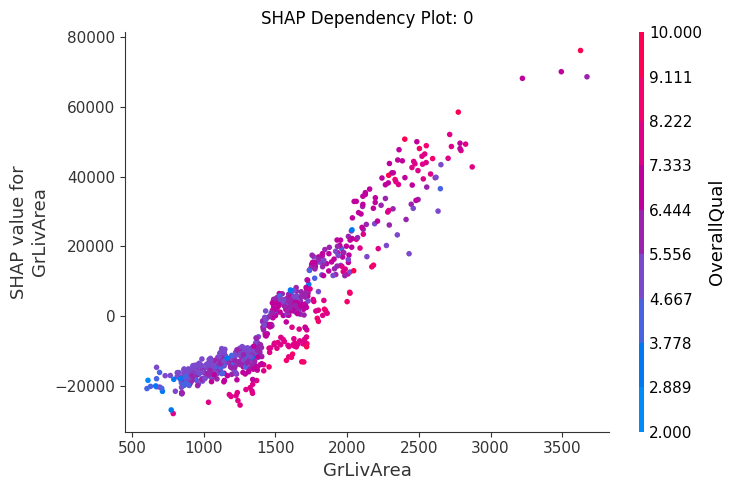

<Figure size 600x400 with 0 Axes>

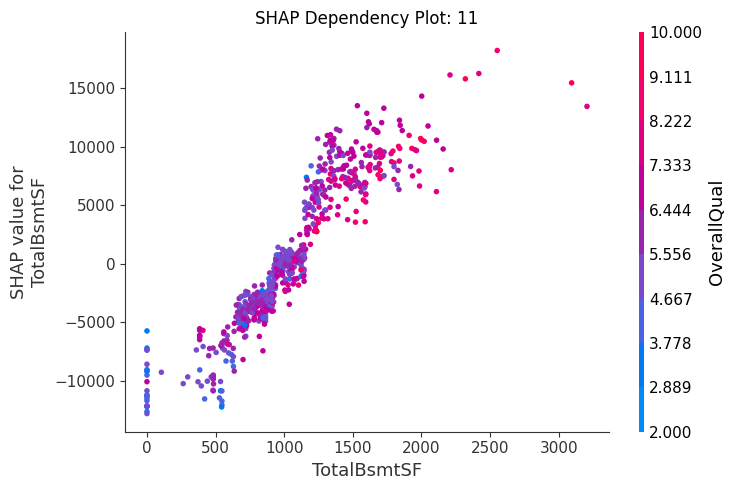

<Figure size 600x400 with 0 Axes>

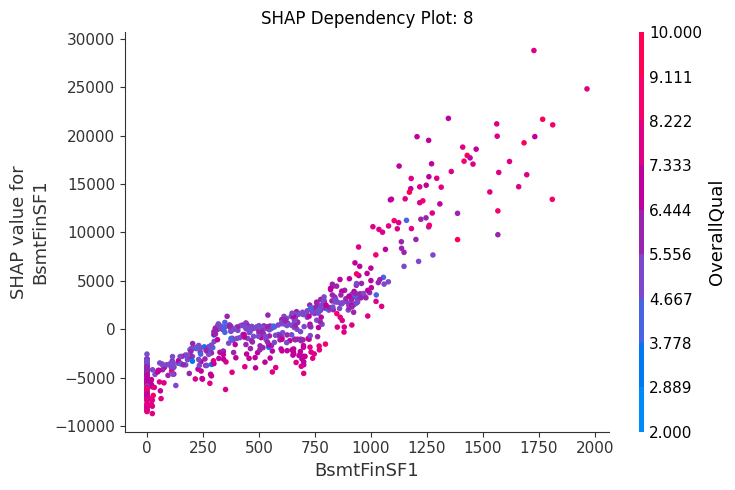

<Figure size 600x400 with 0 Axes>

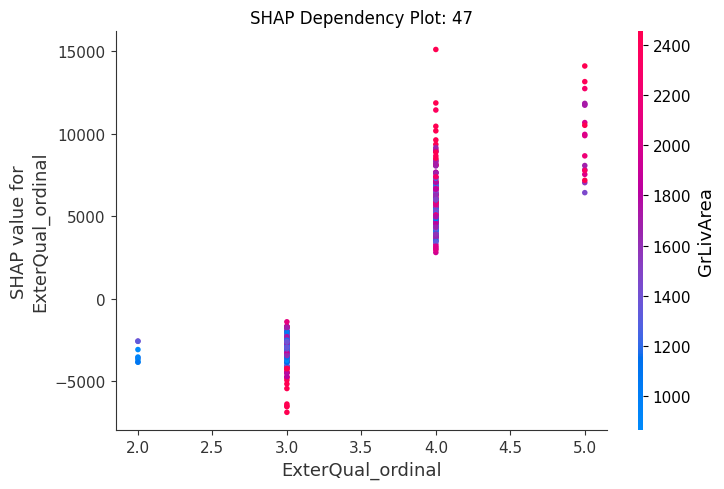

<Figure size 600x400 with 0 Axes>

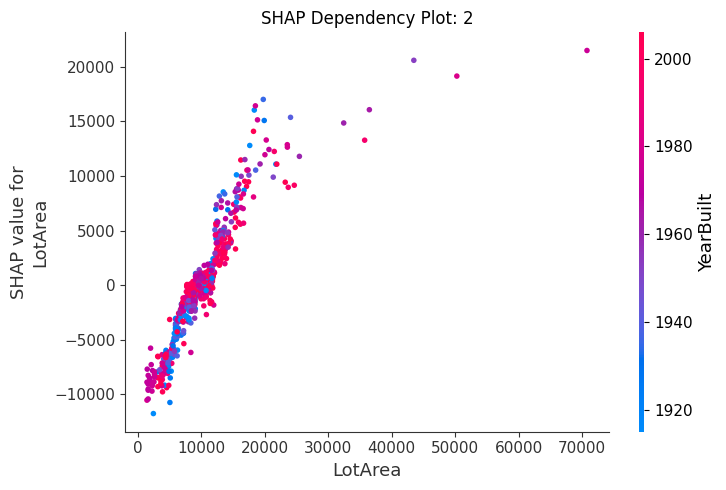

<Figure size 600x400 with 0 Axes>

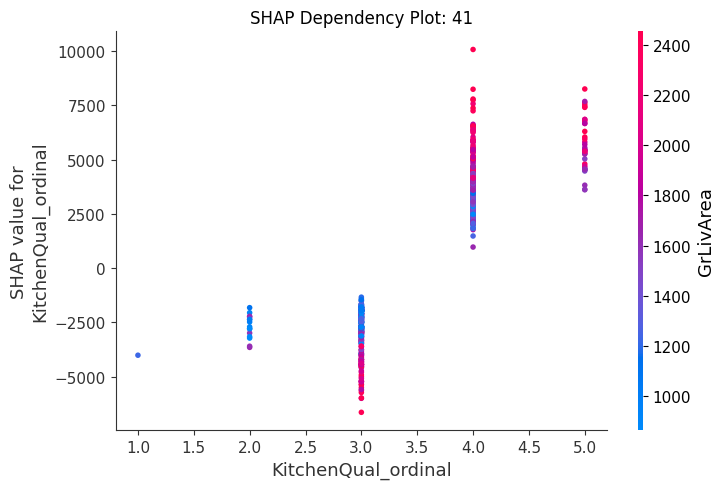

<Figure size 600x400 with 0 Axes>

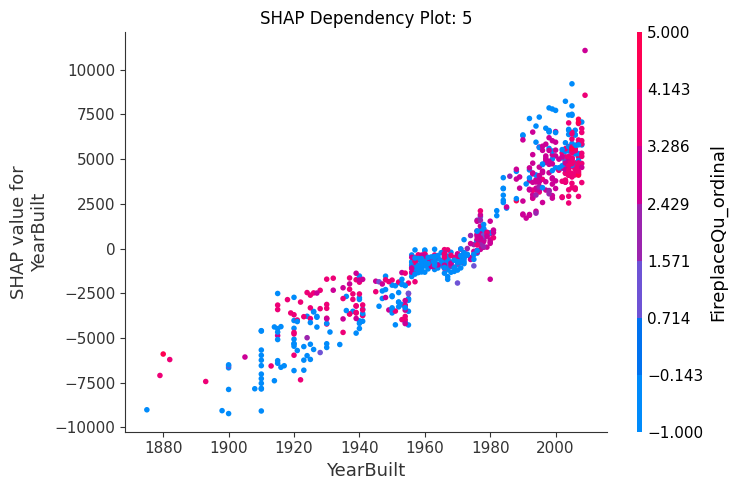

<Figure size 600x400 with 0 Axes>

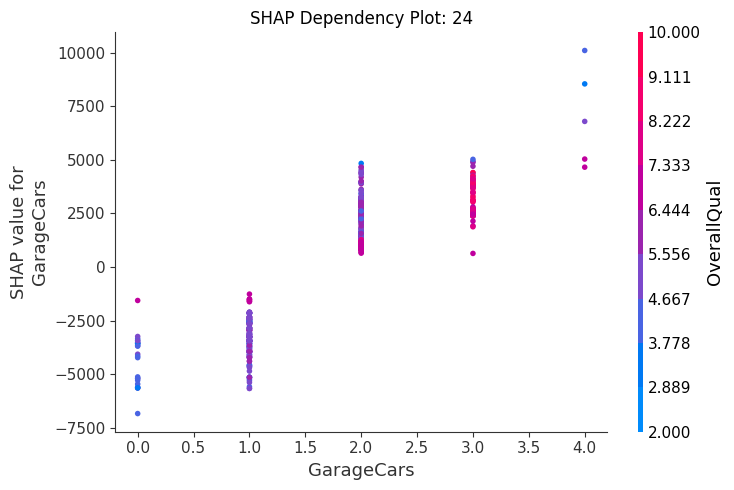

<Figure size 600x400 with 0 Axes>

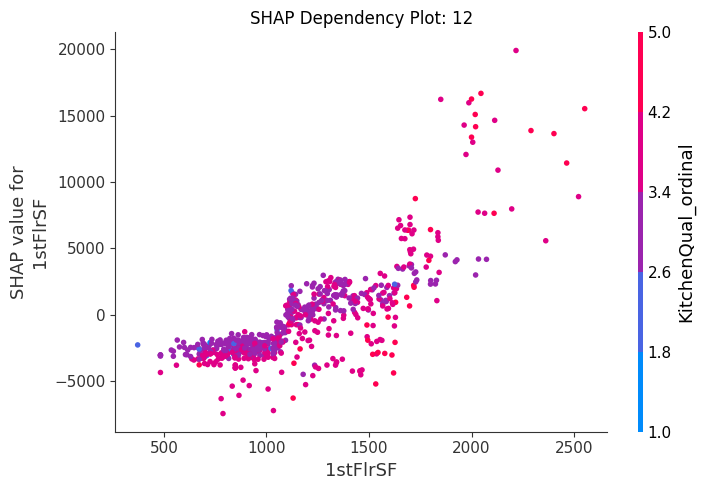

<Figure size 600x400 with 0 Axes>

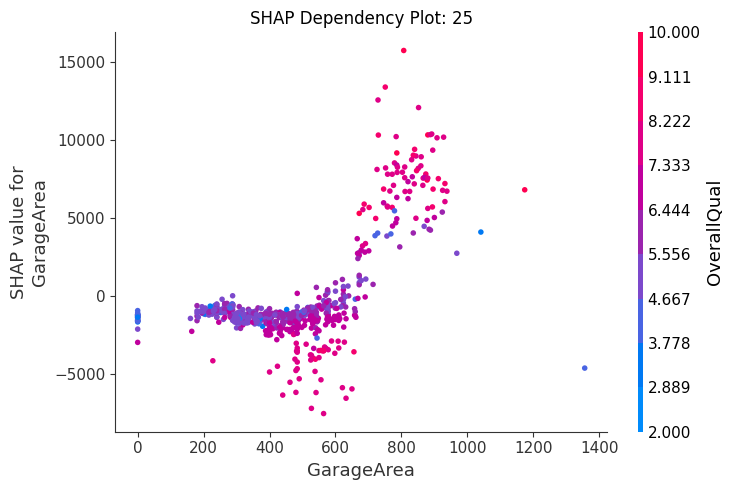

<Figure size 600x400 with 0 Axes>

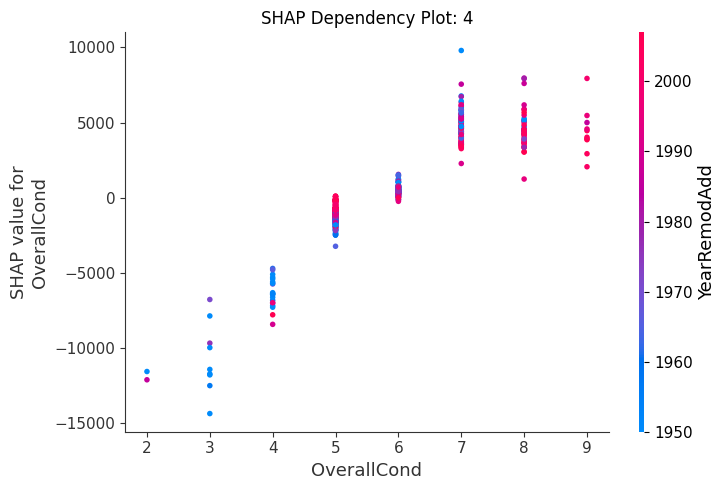

<Figure size 600x400 with 0 Axes>

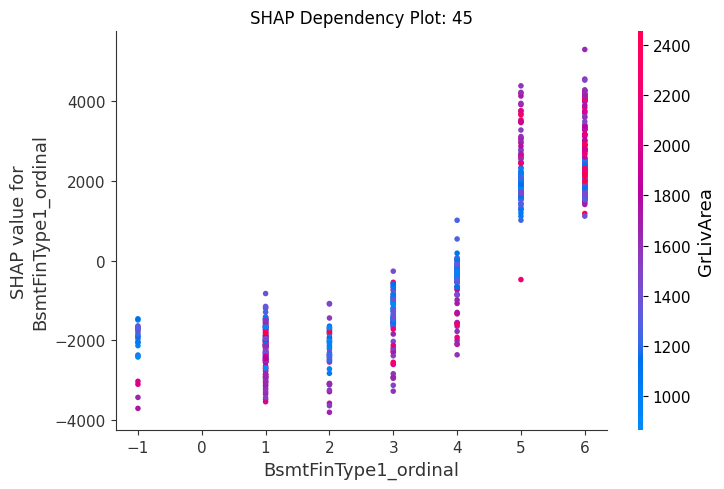

<Figure size 600x400 with 0 Axes>

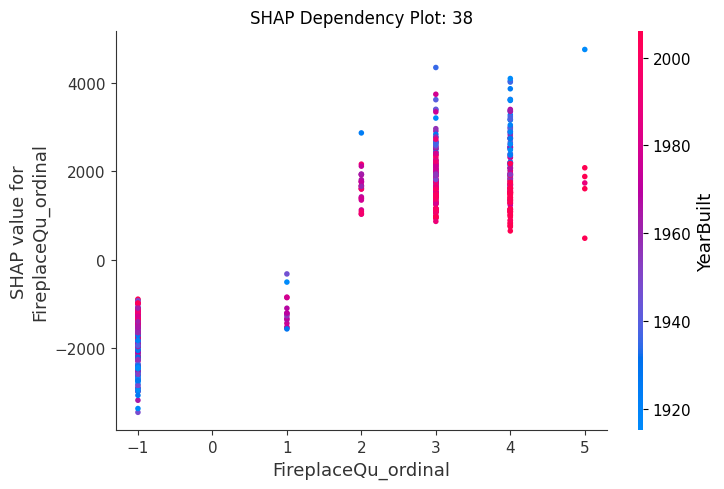

<Figure size 600x400 with 0 Axes>

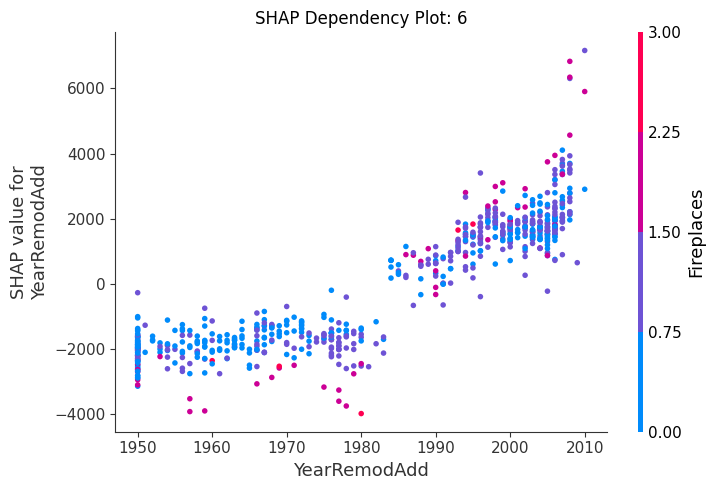

<Figure size 600x400 with 0 Axes>

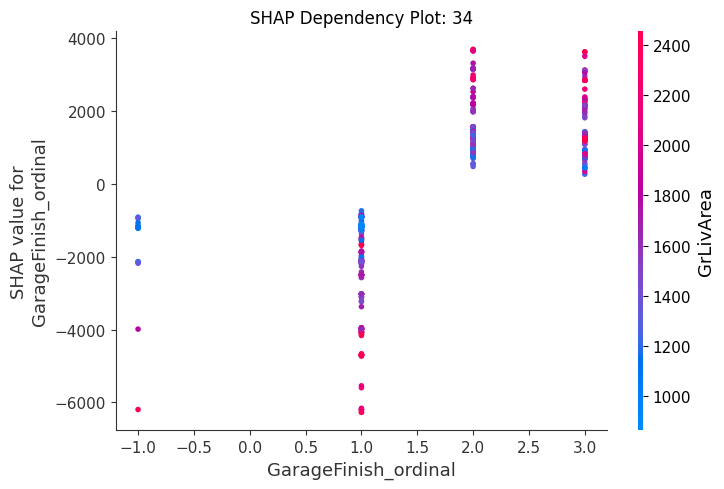

<Figure size 600x400 with 0 Axes>

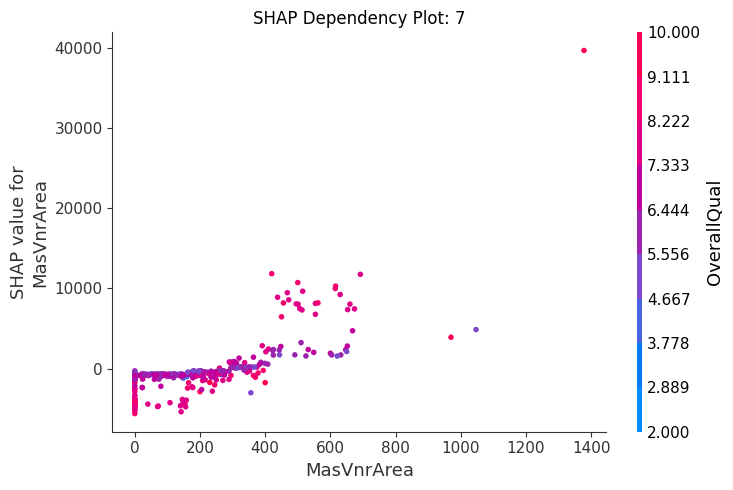

<Figure size 600x400 with 0 Axes>

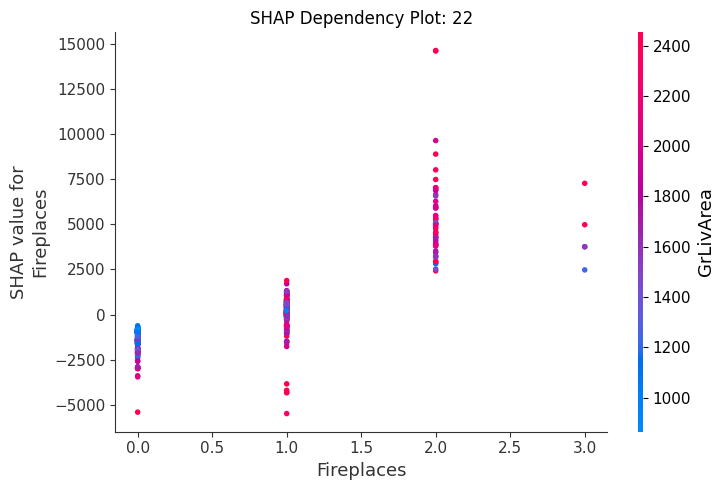

<Figure size 600x400 with 0 Axes>

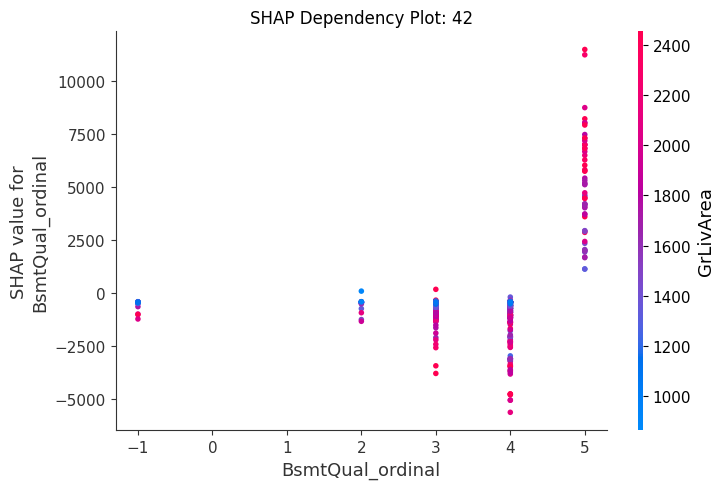

<Figure size 600x400 with 0 Axes>

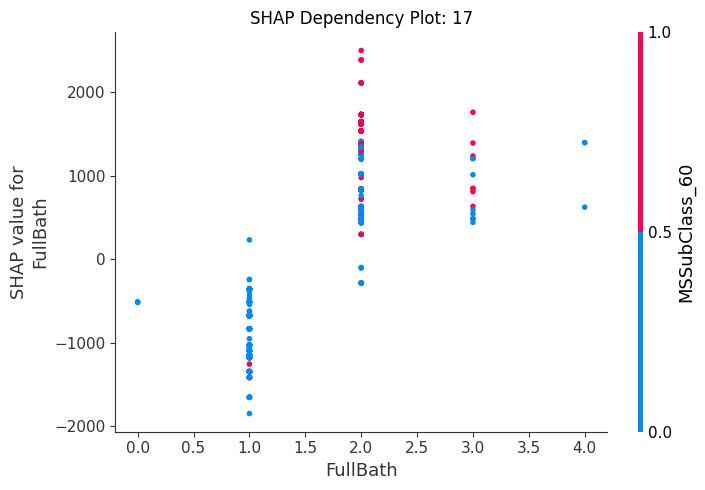

In [62]:
# Select top 20 features
top_features = shap_importance_sorted.head(20).index.tolist()

for feature in top_features:
    plt.figure(figsize=(6, 4))  # Compact size
    
    shap.dependence_plot(
        feature,
        shap_values,
        x_test,
        #interaction_index=None,  # Auto-picks a good feature for color encoding
        show=False
    )
    plt.title(f"SHAP Dependency Plot: {feature}")
    plt.tight_layout()
    plt.show()
    
    # Save plot to file
#     filename = f"shap_dependency_{feature}.png"
#     plt.savefig(filename, dpi=150)
#     plt.close()

# how to interpret
# using OverallQual as an example,
# 1stFlrSF is the most correlated feature with Overall
# you can see larger homes with high OverallQual have even higher SHAP values (strong positive synergy).
# Conversely, small homes (blue dots) with high OverallQual may still not be valued as highly.

### Export lists for final model comparison

### Extract the list of features and features that each one is most correlated with

In [63]:
# Compute correlation matrix for SHAP dependency plot coloring
cor_matrix = x_test.corr()

In [64]:
most_correlated = {}

for feature in x_test.columns:
    # Exclude self-correlation
    corrs = cor_matrix[feature].drop(labels=[feature])
    
    # Drop NaNs
    corrs = corrs.dropna()
    
    # Get feature with highest absolute correlation
    if not corrs.empty:
        most_correlated_feature = corrs.abs().idxmax()
        most_correlated[feature] = most_correlated_feature


In [65]:
correlation_df = pd.DataFrame.from_dict(most_correlated, orient='index', columns=['Most_Correlated_Feature'])
correlation_df.reset_index(inplace=True)
correlation_df.columns = ['feature', 'most_correlated_feature']

In [66]:
correlation_df

,feature,most_correlated_feature
0,GrLivArea,TotRmsAbvGrd
1,LotFrontage,LotArea
2,LotArea,RoofMatl_WdShngl
3,OverallQual,ExterQual_ordinal
4,OverallCond,YearBuilt
...,...,...
222,Electrical_FuseP,MSSubClass_190
223,Electrical_SBrkr,Electrical_FuseF
224,QrtSold_Q2,MoSold_6
225,QrtSold_Q3,MoSold_7


In [67]:
# limit the above list to top 20 features ranked by mean abs SHAP values
rf_SHAP_feature_final = pd.merge(
    shap_importance_sorted.head(20), 
    correlation_df, 
    how='left',
    on = 'feature'
)

rf_SHAP_feature_final['model'] = 'gradient_boosting_5fk'
rf_SHAP_feature_final = rf_SHAP_feature_final[['model', 'feature', 'most_correlated_feature', 'mean_abs_shap']]
rf_SHAP_feature_final

,model,feature,most_correlated_feature,mean_abs_shap
0,gradient_boosting_5fk,OverallQual,ExterQual_ordinal,21187.730596
1,gradient_boosting_5fk,GrLivArea,TotRmsAbvGrd,14832.328991
2,gradient_boosting_5fk,TotalBsmtSF,1stFlrSF,4883.741315
3,gradient_boosting_5fk,BsmtFinSF1,BsmtFinType1_ordinal,4095.194028
4,gradient_boosting_5fk,ExterQual_ordinal,OverallQual,3863.436272
5,gradient_boosting_5fk,LotArea,RoofMatl_WdShngl,3265.264252
6,gradient_boosting_5fk,KitchenQual_ordinal,ExterQual_ordinal,3251.608408
7,gradient_boosting_5fk,YearBuilt,Foundation_PConc,3124.488536
8,gradient_boosting_5fk,GarageCars,GarageArea,2595.719409
9,gradient_boosting_5fk,1stFlrSF,TotalBsmtSF,2593.017263


In [70]:
gbr_feature_importance_final.head(20)

,model,features,importance
3,gradient_boosting_5fk,OverallQual,0.526306
0,gradient_boosting_5fk,GrLivArea,0.147509
11,gradient_boosting_5fk,TotalBsmtSF,0.030675
12,gradient_boosting_5fk,1stFlrSF,0.029313
47,gradient_boosting_5fk,ExterQual_ordinal,0.028630
8,gradient_boosting_5fk,BsmtFinSF1,0.027266
25,gradient_boosting_5fk,GarageArea,0.017839
2,gradient_boosting_5fk,LotArea,0.016419
7,gradient_boosting_5fk,MasVnrArea,0.016156
41,gradient_boosting_5fk,KitchenQual_ordinal,0.015293
